# Neural Style Transfer

###  Is an optimization technique used to take three images, a content image, a stylereference image (such as an artwork by a famous painter), and the input image you want to style and blend them together such that the input image is transformed to look like the content image, but “painted” in the style image.
   ### Using VGG19 model

### Import important Packages

In [ ]:

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn,optim
from torchvision import models,transforms
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


### Load pretrained VGG Model

In [ ]:
vgg=models.vgg19(pretrained=True).features

# Freeze the Features of VGG
for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 115MB/s]


### Run GPU and Pass VGG to Cuda

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def load_image(img_path,max_size=400,shape=None):

    image=Image.open(img_path).convert('RGB')

    if max(image.size)>max_size:
        size=max_size
    else:
        size=max(image.size)

    if shape is not None:
        size=shape

    in_transform=transforms.Compose([transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485,0.456,0.406),(0.299,0.224,0.225))])
    image=in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [121]:
content_path = '/content/drive/MyDrive/Colab Notebooks/Neural Style Transfer/original.jpg'
style_path = '/content/drive/MyDrive/Colab Notebooks/Neural Style Transfer/styles/style-3.jpg'

content = load_image(content_path)
style = load_image(style_path)

In [122]:
def im_convert(tensor):
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image=image.clip(0,1)

    return image


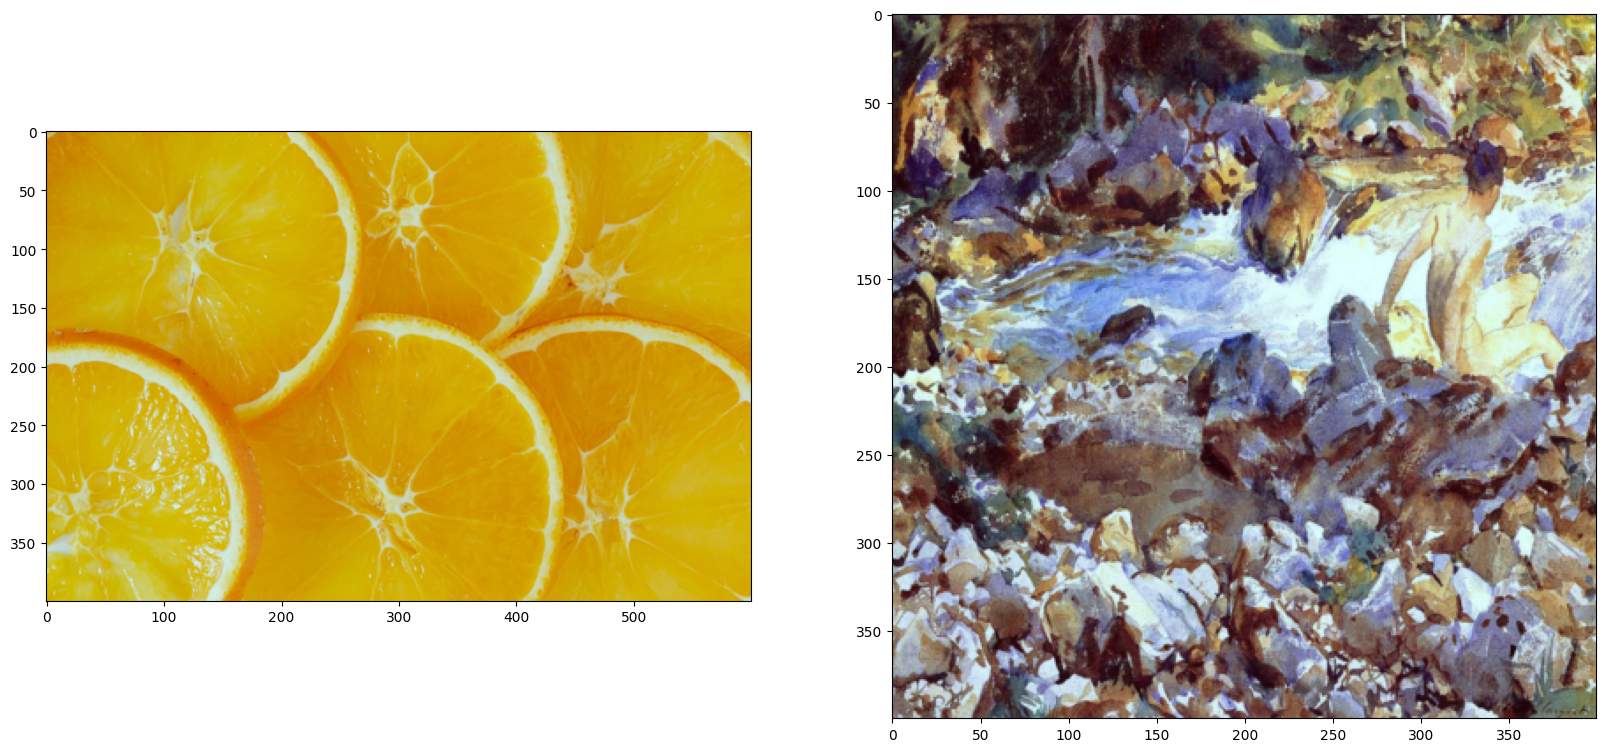

In [123]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [124]:
def get_features(image,model,layers=None):

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [125]:
def gram_matrix(tensor):

    _,d,h,w=tensor.size()

    tensor=tensor.view(d,w*h)       # Tensor *transpose Tensor

    return torch.mm(tensor,tensor.t())

In [126]:
content = content.cuda()
style = style.cuda()

content_features = get_features(content, vgg)     # Extract Features
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True)


In [127]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1000000  # alpha
style_weight = 1000  # beta


Total loss:  142214.53125


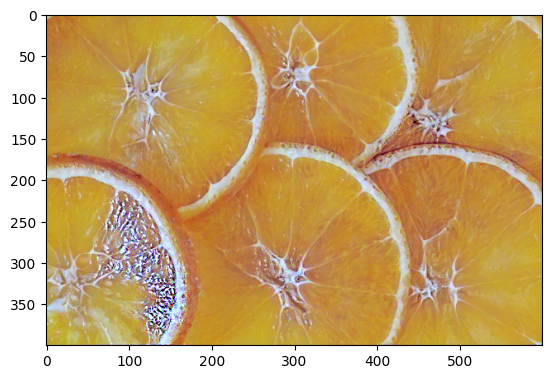

Total loss:  81187.0625


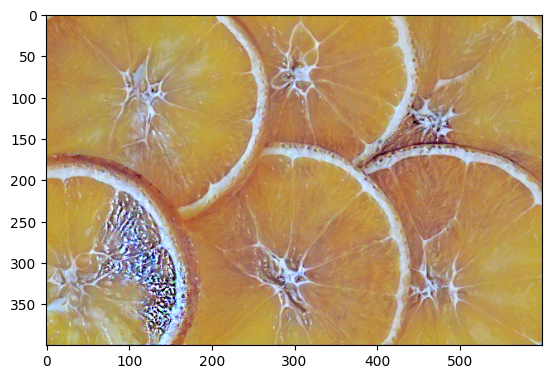

Total loss:  64009.734375


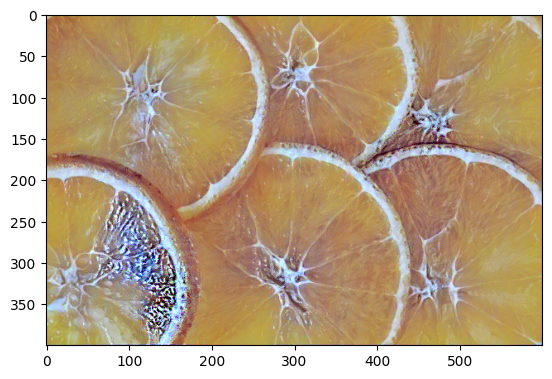

Total loss:  56428.4375


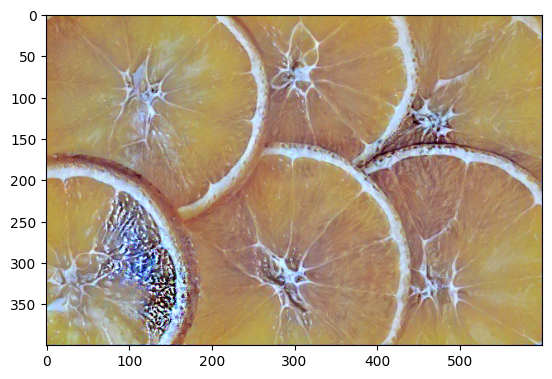

Total loss:  52604.06640625


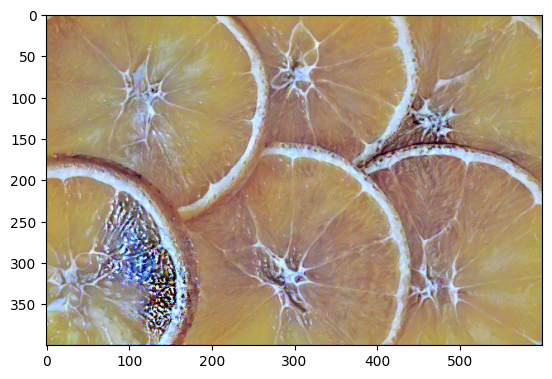

In [128]:
show_every = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.009)
steps = 5000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

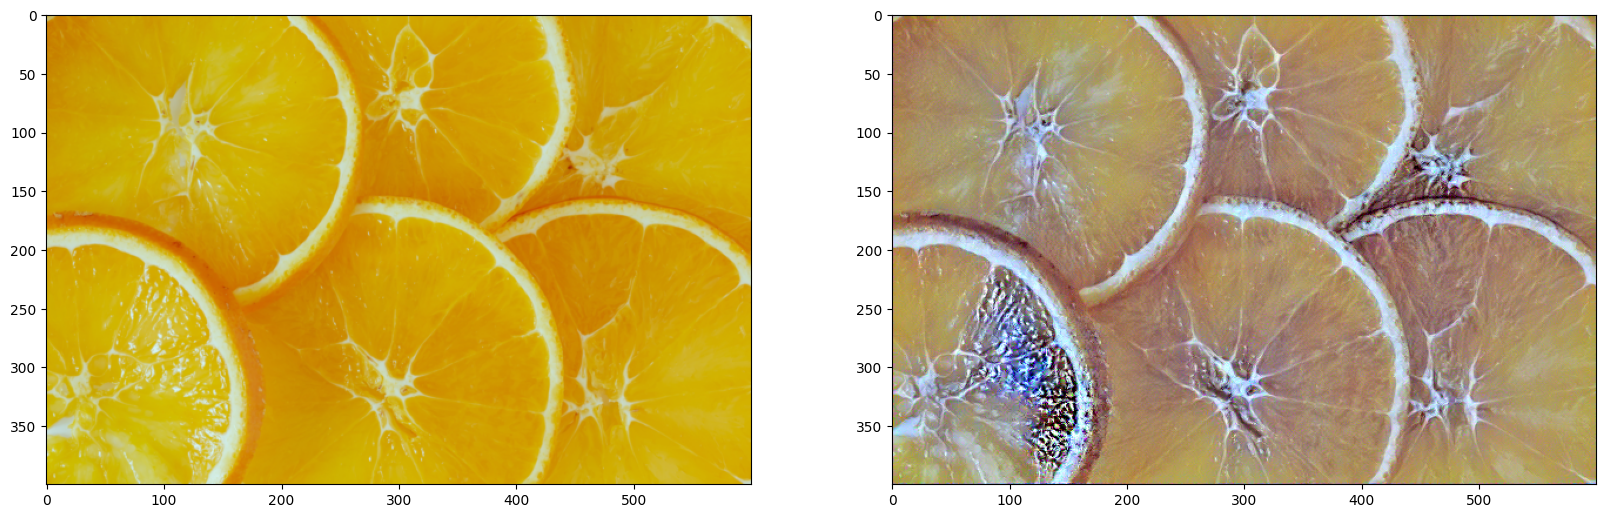

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))